<h1>Outline<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Predicting-the-Landscape-of-Recombination-Using-Deep-Learning" data-toc-modified-id="Predicting-the-Landscape-of-Recombination-Using-Deep-Learning-1">Predicting the Landscape of Recombination Using Deep Learning</a></span></li><li><span><a href="#Recombination---how-it's-estimated" data-toc-modified-id="Recombination---how-it's-estimated-2">Recombination - how it's estimated</a></span></li><li><span><a href="#ReLERNN-outline" data-toc-modified-id="ReLERNN-outline-3">ReLERNN outline</a></span></li><li><span><a href="#A-primer-on-coalescent-simulation" data-toc-modified-id="A-primer-on-coalescent-simulation-4">A primer on coalescent simulation</a></span></li><li><span><a href="#msprime---simulating-genealogies" data-toc-modified-id="msprime---simulating-genealogies-5">msprime - simulating genealogies</a></span></li><li><span><a href="#msprime---adding-recombination" data-toc-modified-id="msprime---adding-recombination-6">msprime - adding recombination</a></span></li><li><span><a href="#msprime---adding-mutations" data-toc-modified-id="msprime---adding-mutations-7">msprime - adding mutations</a></span></li><li><span><a href="#Combining-recombination-and-mutation" data-toc-modified-id="Combining-recombination-and-mutation-8">Combining recombination and mutation</a></span></li><li><span><a href="#Lab-outline" data-toc-modified-id="Lab-outline-9">Lab outline</a></span></li><li><span><a href="#References" data-toc-modified-id="References-10">References</a></span></li></ul></div>

In [3]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'

import utils

# Predicting the Landscape of Recombination Using Deep Learning 

<img src="relernn_ms.png"></img>

## Recombination - what it is

Recombination:

- breaking and repair of DNA strands
- produces new combinations of alleles
- here focus on *meiotic recombination*

Pros: improved adaptation

Cons: break association between beneficial alleles


#### Estimates of recombination rate

Expressed as **recombination frequency** per mega- or kilobase per generation (e.g. cM/Mb)

**centiMorgan (cM)**: distance between chromosomal positions such that 0.01 crossovers expected per generation

<div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0e/Morgan_crossover_1.jpg/440px-Morgan_crossover_1.jpg" width="800px"></img>
</div>

*(Morgan and Foundation 1916)*


## Recombination - why it's important

Historically mainly studied in context of the evolution of sex

Recombination rate variation, its evolution and its effect on evolutionary processes less studied

Recently getting more attention: cf Theme issue ‘Evolutionary causes and consequences of recombination rate variation in sexual organisms' in Philosophical Transactions of the Royal Society B (biological sciences) *(Stapley et al. 2017a)*

### Rate varies between species


<img src="https://royalsocietypublishing.org/cms/asset/3819b484-ada1-42b0-b26c-9dd70c374f59/rstb20160455f02.jpg" alt="Stapley" style="width: 600px;"/>

*(Stapley et al. 2017b)*

### Rate varies within genomes

<img src="https://journals.plos.org/plosgenetics/article/figure/image?size=large&id=10.1371/journal.pgen.1002905.g001" width=600></img>

*(Comeron, Ratnappan, and Bailin 2012)*

### Recombination landscapes and genome architecture

<div><img src="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4617962/bin/1656f01.jpg" width=600></img></div>

*(Burri et al 2015)*

## Variation in recombination rate affects detection of outliers in genome scans under neutrality

<img src="https://onlinelibrary.wiley.com/cms/asset/a0f63d0a-7ca9-4a9f-9508-c5a526e0d15e/mec15690-fig-0002-m.png" width=1000></img>

See comment *It’s time to stop sweeping recombination rate under the genome scan rug* *(Stevison and McGaugh 2020)*

*Variation in recombination rate affects detection of outliers in genome scans under neutrality* *(Booker, Yeaman, and Whitlock 2020)*

Purely theoretical study: simulated data with msprime 

Consequence: genome scans underpowered in low-recombination areas, increased risk of identifying false-positive regions of differentiation

Practical consequence: affects summary statistics and therefore power of said statistic to detect e.g. selection

Novelty here: dependency even for neutrally evolving sites

# Recombination - how it's estimated

<div>
<img src="https://media.springernature.com/lw589/springer-static/image/art%3A10.1038%2Fs41576-020-0240-1/MediaObjects/41576_2020_240_Figa_HTML.png" width=800> </img>
</div>

<br>

*From molecules to populations: appreciating and estimating recombination rate variation (Peñalba and Wolf 2020)*

    
<br>

### Population-based approach (aka *linkage disequilibrium* or *coalescent* -based)

Assumption: recombination main force in determining statistical association between alleles.

Four-gamete test (illustration): only recombination can explain pattern given the infinite-sites model

### Pedigree-based approach

Observe inheritance of alleles in (large) pedigree.

### Gamete-based approach

Gaining traction. Source material not always easily accessible.

There is a need for methods that estimate recombination rates directly from sequence data!

# ReLERNN outline

## Methodology overview

### 1. Estimate parameters for simulation

Estimate parameters for simulation from observed data. Can provide pre-estimates, e.g. stairway plots for demography, ...

### 2. Coalescent simulation

Use parameters to simulate data

### 3. Training

### 4. Prediction

### 5. Bootstrapping of results

<img src="relernn_method.png"></img>

## ReLERNN takes as input genotype alignments and positional data

<table style="font-family: 'Lucida Console', monospace; font-size: 20pt">
    <tr>
        <td>
            <p style="font-family:'Lucida Console', monospace">12345678901234567890123</p>
        </td>
    </tr>
    <tr>
        <td>
            AACGT<b>A</b>AGTACCTAGTTAGTGGA
        </td>
    </tr>
    <tr>
        <td>
            AACGTTAGTACC<b>C</b>AGTTAGTGGA
                    </td>
    </tr>
    <tr>
        <td>
                        AA<b>T</b>GTTAGTACCTAGTTAGTGGA
                    </td>
    </tr>
    <tr>
        <td>
            AA<b>T</b>GTTAGTACCTAGTTAGTGGA
                    </td>
    </tr>
    </table>

<table style="font-family: 'Lucida Console', monospace; font-size: 20pt">
    <tr>
        <td>
            <p style="font-family:'Lucida Console', monospace">363</p>
        </td>
    </tr>
    <tr>
        <td>
            C<b>A</b>T
        </td>
    </tr>
    <tr>
        <td>
            CT<b>C</b>
                    </td>
    </tr>
    <tr>
        <td>
            <b>T</b>TT
                    </td>
    </tr>
    <tr>
                <td>
            <b>T</b>TT
                    </td>
    </tr>
    </table>

We want genotype alignments, i.e. related sequences and positions of segregating sites. How do we get them? Coalescent simulations!

Strategy: simulate data sets with varying recombination (and mutation) rates and store the recombination rate - this is the target of our deep learning model!

# A primer on coalescent simulation

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnrg795/MediaObjects/41576_2002_Article_BFnrg795_Fig4_HTML.jpg?as=webp" width=1600></img>

<br>

*Genealogical trees, coalescent theory and the analysis of genetic polymorphisms (Rosenberg and Nordborg 2002)*

## The coalescent

1. start with i=n chromosomes
2. choose a time until next coalescence $\sim \mathrm{Exp}(i(i-1)/2)$
3. choose two chromosomes at random to coalesce
4. merge the two lineages and set $i \rightarrow i - 1$
5. if $i > 1$, goto 2; if not stop


### Adding mutations

Sample the number of segregating sites $S \sim \mathrm{Po}(T_{total}*\theta/2)$ where $T_{total}$ is the total tree length and $\theta=4N_e\mu$

# msprime - simulating genealogies

Coalescent simulations create genealogies on which random mutations are sprinkled to introduce sequence variation. To begin with, we show the simplest command for simulating a small sample (n=6) of 1kb sequences from a population with a diploid effective population size 1000 ($N_e$=1000) and printing a genealogy:

In [47]:
import msprime
tree_sequence = msprime.simulate(sample_size=4, Ne=1000, length=1e4, random_seed=46)
tree = tree_sequence.first()
print(tree.draw(format="unicode"))

    6  
  ┏━┻━┓
  5   ┃
┏━┻┓  ┃
┃  4  ┃
┃ ┏┻┓ ┃
0 1 2 3



The tree_sequence object is a succinct data structure (compact) representation of trees along the sequence, based on the fact that neighbouring genomic regions have correlated genealogical histories. Since we have no recombination events, there should only be one tree:

In [48]:
len(list(tree_sequence.trees()))

1

# msprime - adding recombination

Recombination events are added via the `recombination_rate` parameter:

In [45]:
tree_sequence = msprime.simulate(sample_size=6, Ne=1000, length=1e4, random_seed=46, recombination_rate=2e-8)
len(list(tree_sequence.trees()))

4

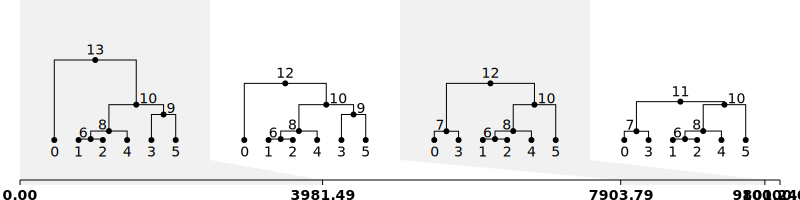

In [46]:
from IPython.core.display import SVG
display(SVG(tree_sequence.draw_svg()))

Note in particular that neighbouring segments have different, but correlated, genealogies.

If we could infer genealogies along a sequence, we could also infer the recombination break points. However, in order to infer genealogies, we need sequence variation, or mutations.

# msprime - adding mutations

In [49]:
tree_sequence = msprime.simulate(sample_size=6, Ne=1000, length=1e5, random_seed=46, mutation_rate=1e-8)
tree = tree_sequence.first()
for site in tree.sites():
    for mutation in site.mutations:
        print("Mutation @ position {:.2f} over node {}".format(site.position, mutation.node))

Mutation @ position 9684.21 over node 2
Mutation @ position 15035.89 over node 7
Mutation @ position 17880.71 over node 2
Mutation @ position 23925.52 over node 8
Mutation @ position 29009.12 over node 6
Mutation @ position 42881.62 over node 2
Mutation @ position 45500.39 over node 4
Mutation @ position 45876.04 over node 2
Mutation @ position 55598.08 over node 8
Mutation @ position 65918.72 over node 7
Mutation @ position 85216.19 over node 2
Mutation @ position 86713.84 over node 8
Mutation @ position 91784.93 over node 7


We can illustrate where the mutations occur by plotting the tree in svg format:

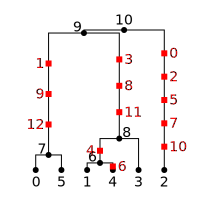

In [50]:
display(SVG(tree.draw_svg()))

# Combining recombination and mutation

The data we want consists of both recombination and mutation! Hence, we simply use a combination of the parameters `recombination_rate` and `mutation_rate`:

In [51]:
tree_sequence = msprime.simulate(sample_size=6, Ne=1000, length=1e4, random_seed=46, mutation_rate=1e-7, recombination_rate=2e-8)

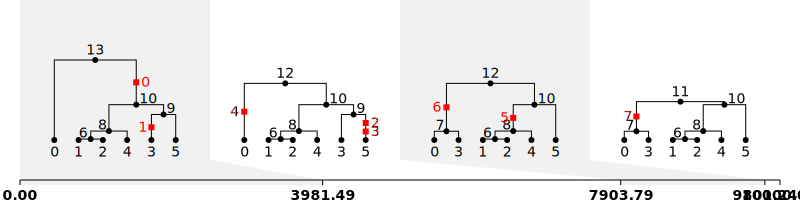

In [52]:
display(SVG(tree_sequence.draw_svg()))

We can print the resulting sequences and compare with the trees to see where mutations occur. For instance, mutation 0 corresponds to the first column in the matrix, and affects individuals 1 and 3.

In [53]:
tree_sequence.genotype_matrix().T

array([[0, 0, 0, 0, 1, 0, 1, 1],
       [1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1, 0, 0],
       [1, 1, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 1, 1, 0, 0, 0, 0]], dtype=int8)

As an example, individual (leaf) with index 0 has mutations 4, 6, and 7, and its sequence is `00001011`. 

# Lab outline


## Simulate data with msprime

## Preprocess data

## Present data in batches with tensorflow.utils.Sequence

## Train and test model on simulated toy examples



Lab is a blueprint of how a population genomics deep learning project could be conducted!

# References


Adrion, Jeffrey R., Jared G. Galloway, and Andrew D. Kern. 2020. “Predicting the Landscape of Recombination Using Deep Learning.” Molecular Biology and Evolution 37 (6): 1790–1808. doi:10.1093/molbev/msaa038.

Booker, Tom R., Sam Yeaman, and Michael C. Whitlock. 2020. “Variation in Recombination Rate Affects Detection of Outliers in Genome Scans under Neutrality.” Molecular Ecology n/a (n/a). Accessed October 26. doi:10.1111/mec.15501.

Burri, Reto, Alexander Nater, Takeshi Kawakami, Carina F. Mugal, Pall I. Olason, Linnea Smeds, Alexander Suh, et al. 2015. “Linked Selection and Recombination Rate Variation Drive the Evolution of the Genomic Landscape of Differentiation across the Speciation Continuum of Ficedula Flycatchers.” Genome Research 25 (11): 1656–65. doi:10.1101/gr.196485.115.

Comeron, Josep M., Ramesh Ratnappan, and Samuel Bailin. 2012. “The Many Landscapes of Recombination in Drosophila Melanogaster.” PLOS Genetics 8 (10): e1002905. doi:10.1371/journal.pgen.1002905.

Morgan, Thomas Hunt, and Louis Clark Vanuxem Foundation. 1916. A Critique of the Theory of Evolution. Princeton,: Princeton University Press,. https://www.biodiversitylibrary.org/bibliography/37670.

Peñalba, Joshua V., and Jochen B. W. Wolf. 2020. “From Molecules to Populations: Appreciating and Estimating Recombination Rate Variation.” Nature Reviews Genetics 21 (8): 476–92. doi:10.1038/s41576-020-0240-1.

Rosenberg, Noah A., and Magnus Nordborg. 2002. “Genealogical Trees, Coalescent Theory and the Analysis of Genetic Polymorphisms.” Nature Reviews Genetics 3 (5): 380–90. doi:10.1038/nrg795.

Stapley, Jessica, Philine G. D. Feulner, Susan E. Johnston, Anna W. Santure, and Carole M. Smadja. 2017a. “Recombination: The Good, the Bad and the Variable.” Philosophical Transactions of the Royal Society B: Biological Sciences 372 (1736): 20170279. doi:10.1098/rstb.2017.0279.

———. 2017b. “Variation in Recombination Frequency and Distribution across Eukaryotes: Patterns and Processes.” Philosophical Transactions of the Royal Society B: Biological Sciences 372 (1736): 20160455. doi:10.1098/rstb.2016.0455.

Stevison, Laurie S., and Suzanne E. McGaugh. 2020. “It’s Time to Stop Sweeping Recombination Rate under the Genome Scan Rug.” Molecular Ecology n/a (n/a). Accessed October 26. doi:10.1111/mec.15690.